## import packages

In [23]:
import pandas as pd
import numpy as np 
import mlflow
import sklearn
from datetime import date

# for future reference: this code was run on
!python -V
print(f'mlflow {mlflow.__version__}')
print(f'pandas {pd.__version__}')
print(f'numpy {np.__version__}')
print(f'sklearn {sklearn.__version__}')
print(f'last successful RunAll date {date.today()}')

Python 3.11.9
mlflow 2.12.2
pandas 2.2.2
numpy 1.26.4
sklearn 1.4.2
last successful RunAll date 2024-05-27


In [21]:
import pickle

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

In [7]:
# mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000/")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='mlflow-artifacts:/525565821708043170', creation_time=1716614083982, experiment_id='525565821708043170', last_update_time=1716614083982, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [8]:
df = pd.read_parquet('../data/raw/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [9]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

9.838799799829577

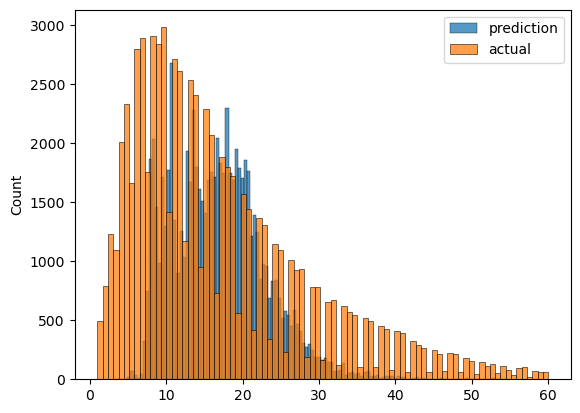

In [10]:
sns.histplot(y_pred, label='prediction')
sns.histplot(y_train, label='actual')

plt.legend();

In [11]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [12]:
df_train = read_dataframe('../data/raw/green_tripdata_2021-01.parquet')
df_val = read_dataframe('../data/raw/green_tripdata_2021-02.parquet')

In [13]:
len(df_train), len(df_val)

(73908, 61921)

In [14]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [15]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [16]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [57]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.758715209663881

In [58]:
with open('../models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

### using lasso

In [59]:
with mlflow.start_run():

    mlflow.set_tag("developer", "ellacharmed")

    mlflow.log_param("train-data-path", "../data/raw/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path", "../data/raw/green_tripdata_2021-02.parquet")

    alpha = 0.1
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

    mlflow.log_artifact(local_path="../models/lin_reg.bin", artifact_path="models_pickle")

### using xgboost

In [60]:
import xgboost as xgb

In [61]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [62]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [63]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [64]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [05:30:11] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.18057                          
[1]	validation-rmse:8.86317                           
[2]	validation-rmse:8.03595                           
[3]	validation-rmse:7.52294                           
[4]	validation-rmse:7.21561                           
[5]	validation-rmse:7.02299                           
[6]	validation-rmse:6.90505                           
[7]	validation-rmse:6.83187                           
[8]	validation-rmse:6.78707                           
[9]	validation-rmse:6.75684                           
[10]	validation-rmse:6.73309                          
[11]	validation-rmse:6.71821                          
[12]	validation-rmse:6.70773                          
[13]	validation-rmse:6.69892                          
[14]	validation-rmse:6.69204                          
[15]	validation-rmse:6.68691                          
[16]	validation-rmse:6.68437                          
[17]	validation-rmse:6.68187                          
[18]	valid

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [05:31:48] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.36573                                                      
[1]	validation-rmse:6.64704                                                      
[2]	validation-rmse:6.51026                                                      
[3]	validation-rmse:6.47311                                                      
[4]	validation-rmse:6.45108                                                      
[5]	validation-rmse:6.44080                                                      
[6]	validation-rmse:6.43398                                                      
[7]	validation-rmse:6.42917                                                      
[8]	validation-rmse:6.42015                                                      
[9]	validation-rmse:6.41338                                                      
[10]	validation-rmse:6.40923                                                     
[11]	validation-rmse:6.40364                                                     
[12]	validation-

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [05:32:41] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.65890                                                     
[1]	validation-rmse:7.27297                                                     
[2]	validation-rmse:6.77863                                                     
[3]	validation-rmse:6.58985                                                     
[4]	validation-rmse:6.51687                                                     
[5]	validation-rmse:6.47943                                                     
[6]	validation-rmse:6.45510                                                     
[7]	validation-rmse:6.44419                                                     
[8]	validation-rmse:6.43401                                                     
[9]	validation-rmse:6.42894                                                     
[10]	validation-rmse:6.42501                                                    
[11]	validation-rmse:6.42204                                                    
[12]	validation-rmse:6.41765

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [05:33:57] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.57768                                                    
[1]	validation-rmse:8.13588                                                    
[2]	validation-rmse:7.38942                                                    
[3]	validation-rmse:7.01142                                                    
[4]	validation-rmse:6.81499                                                    
[5]	validation-rmse:6.71135                                                    
[6]	validation-rmse:6.64474                                                    
[7]	validation-rmse:6.60635                                                    
[8]	validation-rmse:6.58011                                                    
[9]	validation-rmse:6.56358                                                    
[10]	validation-rmse:6.54363                                                   
[11]	validation-rmse:6.53034                                                   
[12]	validation-rmse:6.52234            

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [05:35:38] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.22088                                                     
[1]	validation-rmse:8.90706                                                      
[2]	validation-rmse:8.06851                                                      
[3]	validation-rmse:7.54087                                                      
[4]	validation-rmse:7.21457                                                      
[5]	validation-rmse:7.01428                                                      
[6]	validation-rmse:6.88917                                                      
[7]	validation-rmse:6.80664                                                      
[8]	validation-rmse:6.75253                                                      
[9]	validation-rmse:6.71855                                                      
[10]	validation-rmse:6.69405                                                     
[11]	validation-rmse:6.67646                                                     
[12]	validation-

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [05:37:09] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.19704                                                      
[1]	validation-rmse:6.60855                                                      
[2]	validation-rmse:6.52433                                                      
[3]	validation-rmse:6.50428                                                      
[4]	validation-rmse:6.49675                                                      
[5]	validation-rmse:6.48338                                                      
[6]	validation-rmse:6.47728                                                      
[7]	validation-rmse:6.47409                                                      
[8]	validation-rmse:6.46585                                                      
[9]	validation-rmse:6.45942                                                      
[10]	validation-rmse:6.45437                                                     
[11]	validation-rmse:6.44810                                                     
[12]	validation-

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [05:37:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.64724                                                    
[1]	validation-rmse:7.28356                                                    
[2]	validation-rmse:6.79797                                                    
[3]	validation-rmse:6.61601                                                    
[4]	validation-rmse:6.53865                                                    
[5]	validation-rmse:6.49735                                                    
[6]	validation-rmse:6.47224                                                    
[7]	validation-rmse:6.45734                                                    
[8]	validation-rmse:6.44505                                                    
[9]	validation-rmse:6.43787                                                    
[10]	validation-rmse:6.43329                                                   
[11]	validation-rmse:6.42845                                                   
[12]	validation-rmse:6.42455            

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [05:39:00] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.62066                                                   
[1]	validation-rmse:11.08578                                                   
[2]	validation-rmse:10.60373                                                   
[3]	validation-rmse:10.16899                                                   
[4]	validation-rmse:9.78026                                                    
[5]	validation-rmse:9.43231                                                    
[6]	validation-rmse:9.12129                                                    
[7]	validation-rmse:8.84432                                                    
[8]	validation-rmse:8.59863                                                    
[9]	validation-rmse:8.37970                                                    
[10]	validation-rmse:8.18595                                                   
[11]	validation-rmse:8.01319                                                   
[12]	validation-rmse:7.86054            

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [05:40:40] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.34799                                                   
[1]	validation-rmse:10.60111                                                   
[2]	validation-rmse:9.96010                                                    
[3]	validation-rmse:9.41229                                                    
[4]	validation-rmse:8.94644                                                    
[5]	validation-rmse:8.54871                                                    
[6]	validation-rmse:8.21581                                                    
[7]	validation-rmse:7.93397                                                    
[8]	validation-rmse:7.69868                                                    
[9]	validation-rmse:7.50036                                                    
[10]	validation-rmse:7.33593                                                   
[11]	validation-rmse:7.19728                                                   
[12]	validation-rmse:7.08167            

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [05:44:46] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.20920                                                      
[1]	validation-rmse:10.36960                                                      
[2]	validation-rmse:9.67204                                                       
[3]	validation-rmse:9.09627                                                       
[4]	validation-rmse:8.62281                                                       
[5]	validation-rmse:8.23741                                                       
[6]	validation-rmse:7.92409                                                       
[7]	validation-rmse:7.67041                                                       
[8]	validation-rmse:7.46720                                                       
[9]	validation-rmse:7.30196                                                       
[10]	validation-rmse:7.16882                                                      
[11]	validation-rmse:7.06232                                                      
[12]

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [05:46:53] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.47966                                                        
[1]	validation-rmse:6.68740                                                        
[2]	validation-rmse:6.52939                                                        
[3]	validation-rmse:6.48525                                                        
[4]	validation-rmse:6.46997                                                        
[5]	validation-rmse:6.45548                                                        
[6]	validation-rmse:6.44812                                                        
[7]	validation-rmse:6.44008                                                        
[8]	validation-rmse:6.43352                                                        
[9]	validation-rmse:6.42382                                                        
[10]	validation-rmse:6.41966                                                       
[11]	validation-rmse:6.41506                                                

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [05:47:59] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.74974                                                        
[1]	validation-rmse:6.75957                                                        
[2]	validation-rmse:6.54810                                                        
[3]	validation-rmse:6.48641                                                        
[4]	validation-rmse:6.45784                                                        
[5]	validation-rmse:6.44661                                                        
[6]	validation-rmse:6.43927                                                        
[7]	validation-rmse:6.43186                                                        
[8]	validation-rmse:6.42767                                                        
[9]	validation-rmse:6.42469                                                        
[10]	validation-rmse:6.41885                                                       
[11]	validation-rmse:6.41728                                                

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [05:48:46] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.02682                                                    
[1]	validation-rmse:8.63517                                                     
[2]	validation-rmse:7.78168                                                     
[3]	validation-rmse:7.26886                                                     
[4]	validation-rmse:6.96313                                                     
[5]	validation-rmse:6.78125                                                     
[6]	validation-rmse:6.66915                                                     
[7]	validation-rmse:6.59915                                                     
[8]	validation-rmse:6.55247                                                     
[9]	validation-rmse:6.51991                                                     
[10]	validation-rmse:6.49533                                                    
[11]	validation-rmse:6.48069                                                    
[12]	validation-rmse:6.46920

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [05:50:21] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.55099                                                     
[1]	validation-rmse:7.28068                                                     
[2]	validation-rmse:6.87455                                                     
[3]	validation-rmse:6.72801                                                     
[4]	validation-rmse:6.66546                                                     
[5]	validation-rmse:6.63763                                                     
[6]	validation-rmse:6.61567                                                     
[7]	validation-rmse:6.60288                                                     
[8]	validation-rmse:6.59606                                                     
[9]	validation-rmse:6.59133                                                     
[10]	validation-rmse:6.58514                                                    
[11]	validation-rmse:6.58180                                                    
[12]	validation-rmse:6.57737

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [05:51:20] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.35978                                                    
[1]	validation-rmse:10.62455                                                    
[2]	validation-rmse:9.99158                                                     
[3]	validation-rmse:9.44982                                                     
[4]	validation-rmse:8.98867                                                     
[5]	validation-rmse:8.59900                                                     
[6]	validation-rmse:8.26831                                                     
[7]	validation-rmse:7.99049                                                     
[8]	validation-rmse:7.75668                                                     
[9]	validation-rmse:7.55977                                                     
[10]	validation-rmse:7.39805                                                    
[11]	validation-rmse:7.26054                                                    
[12]	validation-rmse:7.14418

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [05:54:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:6.89032                                                      
[4]	validation-rmse:6.84618                                                      
[5]	validation-rmse:6.83016                                                      
[6]	validation-rmse:6.82446                                                      
[7]	validation-rmse:6.81969                                                      
[8]	validation-rmse:6.81562                                                      
[9]	validation-rmse:6.80844                                                      
[10]	validation-rmse:6.80337                                                     
[11]	validation-rmse:6.79786                                                     
[12]	validation-rmse:6.79295                                                     
[13]	validation-rmse:6.79116                                                     
[14]	validation-rmse:6.78229                                                     
[15]	validation-

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [05:56:00] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.57562                                                   
[1]	validation-rmse:11.00439                                                   
[2]	validation-rmse:10.49392                                                   
[3]	validation-rmse:10.03905                                                   
[4]	validation-rmse:9.63434                                                    
[5]	validation-rmse:9.27578                                                    
[6]	validation-rmse:8.95849                                                    
[7]	validation-rmse:8.67834                                                    
[8]	validation-rmse:8.43179                                                    
[9]	validation-rmse:8.21578                                                    
[10]	validation-rmse:8.02559                                                   
[11]	validation-rmse:7.85881                                                   
[12]	validation-rmse:7.71287            

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [05:57:32] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.23504                                                   
[1]	validation-rmse:10.41347                                                   
[2]	validation-rmse:9.72780                                                    
[3]	validation-rmse:9.15830                                                    
[4]	validation-rmse:8.68947                                                    
[5]	validation-rmse:8.30382                                                    
[6]	validation-rmse:7.99064                                                    
[7]	validation-rmse:7.73561                                                    
[8]	validation-rmse:7.52911                                                    
[9]	validation-rmse:7.36184                                                    
[10]	validation-rmse:7.22571                                                   
[11]	validation-rmse:7.11450                                                   
[12]	validation-rmse:7.02314            

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:01:11] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.35118                                                      
[1]	validation-rmse:7.93026                                                      
[2]	validation-rmse:7.26953                                                      
[3]	validation-rmse:6.95831                                                      
[4]	validation-rmse:6.81189                                                      
[5]	validation-rmse:6.73203                                                      
[6]	validation-rmse:6.69695                                                      
[7]	validation-rmse:6.67304                                                      
[8]	validation-rmse:6.65686                                                      
[9]	validation-rmse:6.64931                                                      
[10]	validation-rmse:6.64146                                                     
[11]	validation-rmse:6.63868                                                     
[12]	validation-

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:02:21] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.24817                                                      
[1]	validation-rmse:6.67981                                                      
[2]	validation-rmse:6.58098                                                      
[3]	validation-rmse:6.55498                                                      
[4]	validation-rmse:6.55166                                                      
[5]	validation-rmse:6.54037                                                      
[6]	validation-rmse:6.53341                                                      
[7]	validation-rmse:6.52066                                                      
[8]	validation-rmse:6.51216                                                      
[9]	validation-rmse:6.50760                                                      
[10]	validation-rmse:6.50720                                                     
[11]	validation-rmse:6.49816                                                     
[12]	validation-

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:02:57] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.80738                                                  
[1]	validation-rmse:11.42862                                                  
[2]	validation-rmse:11.07536                                                  
[3]	validation-rmse:10.74626                                                  
[4]	validation-rmse:10.43995                                                  
[5]	validation-rmse:10.15518                                                  
[6]	validation-rmse:9.89071                                                   
[7]	validation-rmse:9.64534                                                   
[8]	validation-rmse:9.41767                                                   
[9]	validation-rmse:9.20711                                                   
[10]	validation-rmse:9.01235                                                  
[11]	validation-rmse:8.83217                                                  
[12]	validation-rmse:8.66583                        

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:07:19] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.92407                                                     
[1]	validation-rmse:9.91019                                                      
[2]	validation-rmse:9.11853                                                      
[3]	validation-rmse:8.51749                                                      
[4]	validation-rmse:8.05191                                                      
[5]	validation-rmse:7.70847                                                      
[6]	validation-rmse:7.44215                                                      
[7]	validation-rmse:7.24408                                                      
[8]	validation-rmse:7.09651                                                      
[9]	validation-rmse:6.98001                                                      
[10]	validation-rmse:6.89294                                                     
[11]	validation-rmse:6.82738                                                     
[12]	validation-

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:09:58] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.76893                                                     
[1]	validation-rmse:11.35698                                                     
[2]	validation-rmse:10.97523                                                     
[3]	validation-rmse:10.62048                                                     
[4]	validation-rmse:10.29362                                                     
[5]	validation-rmse:9.99008                                                      
[6]	validation-rmse:9.71152                                                      
[7]	validation-rmse:9.45312                                                      
[8]	validation-rmse:9.21728                                                      
[9]	validation-rmse:8.99783                                                      
[10]	validation-rmse:8.79726                                                     
[11]	validation-rmse:8.61380                                                     
[12]	validation-

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:13:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.95718                                                     
[1]	validation-rmse:9.96229                                                      
[2]	validation-rmse:9.18661                                                      
[3]	validation-rmse:8.58268                                                      
[4]	validation-rmse:8.11277                                                      
[5]	validation-rmse:7.74961                                                      
[6]	validation-rmse:7.47370                                                      
[7]	validation-rmse:7.27041                                                      
[8]	validation-rmse:7.11269                                                      
[9]	validation-rmse:6.99392                                                      
[10]	validation-rmse:6.89641                                                     
[11]	validation-rmse:6.82582                                                     
[12]	validation-

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:17:02] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.53687                                                     
[1]	validation-rmse:10.93260                                                     
[2]	validation-rmse:10.39501                                                     
[3]	validation-rmse:9.91692                                                      
[4]	validation-rmse:9.49338                                                      
[5]	validation-rmse:9.11949                                                      
[6]	validation-rmse:8.79014                                                      
[7]	validation-rmse:8.50111                                                      
[8]	validation-rmse:8.24745                                                      
[9]	validation-rmse:8.02530                                                      
[10]	validation-rmse:7.83114                                                     
[11]	validation-rmse:7.66190                                                     
[12]	validation-

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:22:45] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.43118                                                     
[1]	validation-rmse:10.74964                                                     
[2]	validation-rmse:10.15805                                                     
[3]	validation-rmse:9.64600                                                      
[4]	validation-rmse:9.20497                                                      
[5]	validation-rmse:8.82661                                                      
[6]	validation-rmse:8.50303                                                      
[7]	validation-rmse:8.22698                                                      
[8]	validation-rmse:7.99259                                                      
[9]	validation-rmse:7.79385                                                      
[10]	validation-rmse:7.62535                                                     
[11]	validation-rmse:7.48258                                                     
[12]	validation-

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:26:15] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.70308                                                     
[1]	validation-rmse:9.57135                                                      
[2]	validation-rmse:8.73473                                                      
[3]	validation-rmse:8.12324                                                      
[4]	validation-rmse:7.68665                                                      
[5]	validation-rmse:7.37045                                                      
[6]	validation-rmse:7.14379                                                      
[7]	validation-rmse:6.98275                                                      
[8]	validation-rmse:6.86648                                                      
[9]	validation-rmse:6.77922                                                      
[10]	validation-rmse:6.71701                                                     
[11]	validation-rmse:6.66821                                                     
[12]	validation-

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:28:21] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.86314                                                     
[1]	validation-rmse:9.82024                                                      
[2]	validation-rmse:9.02138                                                      
[3]	validation-rmse:8.41940                                                      
[4]	validation-rmse:7.96718                                                      
[5]	validation-rmse:7.62943                                                      
[6]	validation-rmse:7.38210                                                      
[7]	validation-rmse:7.19729                                                      
[8]	validation-rmse:7.05902                                                      
[9]	validation-rmse:6.95724                                                      
[10]	validation-rmse:6.87810                                                     
[11]	validation-rmse:6.82333                                                     
[12]	validation-

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:30:50] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.67753                                                       
[1]	validation-rmse:9.53861                                                        
[2]	validation-rmse:8.70429                                                        
[3]	validation-rmse:8.10640                                                        
[4]	validation-rmse:7.67798                                                        
[5]	validation-rmse:7.37593                                                        
[6]	validation-rmse:7.16232                                                        
[7]	validation-rmse:7.01082                                                        
[8]	validation-rmse:6.89895                                                        
[9]	validation-rmse:6.82272                                                        
[10]	validation-rmse:6.76626                                                       
[11]	validation-rmse:6.72285                                                

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:33:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.73098                                                       
[1]	validation-rmse:11.28663                                                       
[2]	validation-rmse:10.87726                                                       
[3]	validation-rmse:10.50019                                                       
[4]	validation-rmse:10.15269                                                       
[5]	validation-rmse:9.83436                                                        
[6]	validation-rmse:9.54271                                                        
[7]	validation-rmse:9.27534                                                        
[8]	validation-rmse:9.02969                                                        
[9]	validation-rmse:8.80593                                                        
[10]	validation-rmse:8.60260                                                       
[11]	validation-rmse:8.41646                                                

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:36:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.44894                                                       
[1]	validation-rmse:9.19964                                                        
[2]	validation-rmse:8.32690                                                        
[3]	validation-rmse:7.73549                                                        
[4]	validation-rmse:7.33799                                                        
[5]	validation-rmse:7.07318                                                        
[6]	validation-rmse:6.89216                                                        
[7]	validation-rmse:6.76947                                                        
[8]	validation-rmse:6.68650                                                        
[9]	validation-rmse:6.62830                                                        
[10]	validation-rmse:6.58596                                                       
[11]	validation-rmse:6.55673                                                

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:38:50] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.10692                                                     
[1]	validation-rmse:10.20019                                                     
[2]	validation-rmse:9.46147                                                      
[3]	validation-rmse:8.86583                                                      
[4]	validation-rmse:8.38624                                                      
[5]	validation-rmse:8.00471                                                      
[6]	validation-rmse:7.70353                                                      
[7]	validation-rmse:7.46338                                                      
[8]	validation-rmse:7.27502                                                      
[9]	validation-rmse:7.12654                                                      
[10]	validation-rmse:7.00855                                                     
[11]	validation-rmse:6.91481                                                     
[12]	validation-

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:42:02] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.12318                                                       
[1]	validation-rmse:10.22930                                                       
[2]	validation-rmse:9.49911                                                        
[3]	validation-rmse:8.90783                                                        
[4]	validation-rmse:8.43539                                                        
[5]	validation-rmse:8.05351                                                        
[6]	validation-rmse:7.75378                                                        
[7]	validation-rmse:7.51670                                                        
[8]	validation-rmse:7.32587                                                        
[9]	validation-rmse:7.17638                                                        
[10]	validation-rmse:7.05929                                                       
[11]	validation-rmse:6.96166                                                

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:45:47] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.39957                                                       
[1]	validation-rmse:10.69793                                                       
[2]	validation-rmse:10.08977                                                       
[3]	validation-rmse:9.56649                                                        
[4]	validation-rmse:9.12031                                                        
[5]	validation-rmse:8.73955                                                        
[6]	validation-rmse:8.41455                                                        
[7]	validation-rmse:8.13882                                                        
[8]	validation-rmse:7.90708                                                        
[9]	validation-rmse:7.70985                                                        
[10]	validation-rmse:7.54341                                                       
[11]	validation-rmse:7.40593                                                

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:48:37] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.69308                                                       
[1]	validation-rmse:11.21618                                                       
[2]	validation-rmse:10.77903                                                       
[3]	validation-rmse:10.37912                                                       
[4]	validation-rmse:10.01449                                                       
[5]	validation-rmse:9.68195                                                        
[6]	validation-rmse:9.37885                                                        
[7]	validation-rmse:9.10330                                                        
[8]	validation-rmse:8.85276                                                        
[9]	validation-rmse:8.62602                                                        
[10]	validation-rmse:8.42074                                                       
[11]	validation-rmse:8.23417                                                

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:52:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.10982                                                       
[1]	validation-rmse:8.76354                                                        
[2]	validation-rmse:7.92764                                                        
[3]	validation-rmse:7.41572                                                        
[4]	validation-rmse:7.10447                                                        
[5]	validation-rmse:6.91688                                                        
[6]	validation-rmse:6.80148                                                        
[7]	validation-rmse:6.71791                                                        
[8]	validation-rmse:6.66828                                                        
[9]	validation-rmse:6.63715                                                        
[10]	validation-rmse:6.61180                                                       
[11]	validation-rmse:6.59577                                                

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:53:46] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:7.68869                                                        
[3]	validation-rmse:7.27339                                                        
[4]	validation-rmse:7.05059                                                        
[5]	validation-rmse:6.92860                                                        
[6]	validation-rmse:6.86007                                                        
[7]	validation-rmse:6.81603                                                        
[8]	validation-rmse:6.79111                                                        
[9]	validation-rmse:6.77496                                                        
[10]	validation-rmse:6.76409                                                       
[11]	validation-rmse:6.75267                                                       
[12]	validation-rmse:6.75107                                                       
[13]	validation-rmse:6.74490                                                

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [06:55:00] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.65964                                                       
[1]	validation-rmse:11.15489                                                       
[2]	validation-rmse:10.69519                                                       
[3]	validation-rmse:10.27748                                                       
[4]	validation-rmse:9.89811                                                        
[5]	validation-rmse:9.55476                                                        
[6]	validation-rmse:9.24438                                                        
[7]	validation-rmse:8.96382                                                        
[8]	validation-rmse:8.71074                                                        
[9]	validation-rmse:8.48295                                                        
[10]	validation-rmse:8.27859                                                       
[11]	validation-rmse:8.09491                                                

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:01:48] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.11373                                                       
[1]	validation-rmse:10.21457                                                       
[2]	validation-rmse:9.48143                                                        
[3]	validation-rmse:8.89172                                                        
[4]	validation-rmse:8.42097                                                        
[5]	validation-rmse:8.04615                                                        
[6]	validation-rmse:7.74803                                                        
[7]	validation-rmse:7.51325                                                        
[8]	validation-rmse:7.32842                                                        
[9]	validation-rmse:7.18354                                                        
[10]	validation-rmse:7.06944                                                       
[11]	validation-rmse:6.97988                                                

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:03:37] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.80528                                                        
[1]	validation-rmse:6.77607                                                        
[2]	validation-rmse:6.77696                                                        
[3]	validation-rmse:6.75926                                                        
[4]	validation-rmse:6.75424                                                        
[5]	validation-rmse:6.75300                                                        
[6]	validation-rmse:6.74520                                                        
[7]	validation-rmse:6.73955                                                        
[8]	validation-rmse:6.73984                                                        
[9]	validation-rmse:6.73795                                                        
[10]	validation-rmse:6.73076                                                       
[11]	validation-rmse:6.73749                                                

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:04:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.48796                                                       
[1]	validation-rmse:10.85033                                                       
[2]	validation-rmse:10.28876                                                       
[3]	validation-rmse:9.79699                                                        
[4]	validation-rmse:9.36347                                                        
[5]	validation-rmse:8.98638                                                        
[6]	validation-rmse:8.65879                                                        
[7]	validation-rmse:8.37170                                                        
[8]	validation-rmse:8.12678                                                        
[9]	validation-rmse:7.90845                                                        
[10]	validation-rmse:7.71680                                                       
[11]	validation-rmse:7.56316                                                

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:10:20] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.41265                                                       
[1]	validation-rmse:9.16264                                                        
[2]	validation-rmse:8.31214                                                        
[3]	validation-rmse:7.74998                                                        
[4]	validation-rmse:7.37780                                                        
[5]	validation-rmse:7.13173                                                        
[6]	validation-rmse:6.97231                                                        
[7]	validation-rmse:6.86671                                                        
[8]	validation-rmse:6.79456                                                        
[9]	validation-rmse:6.74258                                                        
[10]	validation-rmse:6.70611                                                       
[11]	validation-rmse:6.68090                                                

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:12:11] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.37528                                                        
[1]	validation-rmse:7.92787                                                        
[2]	validation-rmse:7.23662                                                        
[3]	validation-rmse:6.90967                                                        
[4]	validation-rmse:6.74752                                                        
[5]	validation-rmse:6.65876                                                        
[6]	validation-rmse:6.61187                                                        
[7]	validation-rmse:6.58331                                                        
[8]	validation-rmse:6.56454                                                        
[9]	validation-rmse:6.55374                                                        
[10]	validation-rmse:6.54727                                                       
[11]	validation-rmse:6.54292                                                

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:13:25] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.02099                                                       
[1]	validation-rmse:10.06070                                                       
[2]	validation-rmse:9.29272                                                        
[3]	validation-rmse:8.68598                                                        
[4]	validation-rmse:8.20755                                                        
[5]	validation-rmse:7.83676                                                        
[6]	validation-rmse:7.54850                                                        
[7]	validation-rmse:7.32543                                                        
[8]	validation-rmse:7.15427                                                        
[9]	validation-rmse:7.01899                                                        
[10]	validation-rmse:6.91583                                                       
[11]	validation-rmse:6.83505                                                

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:15:45] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.35120                                                       
[1]	validation-rmse:10.61152                                                       
[2]	validation-rmse:9.97972                                                        
[3]	validation-rmse:9.44183                                                        
[4]	validation-rmse:8.98660                                                        
[5]	validation-rmse:8.60345                                                        
[6]	validation-rmse:8.28201                                                        
[7]	validation-rmse:8.01295                                                        
[8]	validation-rmse:7.78893                                                        
[9]	validation-rmse:7.60224                                                        
[10]	validation-rmse:7.44801                                                       
[11]	validation-rmse:7.31935                                                

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:19:03] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.28659                                                       
[1]	validation-rmse:10.49742                                                       
[2]	validation-rmse:9.82879                                                        
[3]	validation-rmse:9.26591                                                        
[4]	validation-rmse:8.79418                                                        
[5]	validation-rmse:8.39943                                                        
[6]	validation-rmse:8.07266                                                        
[7]	validation-rmse:7.80223                                                        
[8]	validation-rmse:7.57880                                                        
[9]	validation-rmse:7.39560                                                        
[10]	validation-rmse:7.24514                                                       
[11]	validation-rmse:7.12130                                                

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:22:59] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.65495                                                       
[1]	validation-rmse:11.14652                                                       
[2]	validation-rmse:10.68429                                                       
[3]	validation-rmse:10.26479                                                       
[4]	validation-rmse:9.88434                                                        
[5]	validation-rmse:9.54068                                                        
[6]	validation-rmse:9.23030                                                        
[7]	validation-rmse:8.95004                                                        
[8]	validation-rmse:8.69780                                                        
[9]	validation-rmse:8.47189                                                        
[10]	validation-rmse:8.26993                                                       
[11]	validation-rmse:8.08805                                                

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:28:20] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.71796                                                       
[1]	validation-rmse:9.59799                                                        
[2]	validation-rmse:8.76739                                                        
[3]	validation-rmse:8.16525                                                        
[4]	validation-rmse:7.72380                                                        
[5]	validation-rmse:7.41631                                                        
[6]	validation-rmse:7.19569                                                        
[7]	validation-rmse:7.03369                                                        
[8]	validation-rmse:6.92118                                                        
[9]	validation-rmse:6.83831                                                        
[10]	validation-rmse:6.77718                                                       
[11]	validation-rmse:6.72693                                                

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:30:48] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:10.87224                                                       
[2]	validation-rmse:10.31997                                                       
[3]	validation-rmse:9.83711                                                        
[4]	validation-rmse:9.41483                                                        
[5]	validation-rmse:9.04749                                                        
[6]	validation-rmse:8.72833                                                        
[7]	validation-rmse:8.45121                                                        
[8]	validation-rmse:8.21267                                                        
[9]	validation-rmse:8.00865                                                        
[10]	validation-rmse:7.83175                                                       
[11]	validation-rmse:7.68004                                                       
[12]	validation-rmse:7.54949                                                

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:32:04] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.71431                                                        
[1]	validation-rmse:8.30371                                                        
[2]	validation-rmse:7.53321                                                        
[3]	validation-rmse:7.12809                                                        
[4]	validation-rmse:6.90903                                                        
[5]	validation-rmse:6.79657                                                        
[6]	validation-rmse:6.72215                                                        
[7]	validation-rmse:6.68098                                                        
[8]	validation-rmse:6.65539                                                        
[9]	validation-rmse:6.63811                                                        
[10]	validation-rmse:6.62702                                                       
[11]	validation-rmse:6.61886                                                

In [65]:
mlflow.xgboost.autolog(disable=True)

In [66]:
with mlflow.start_run():
    
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    best_params = {
        'min_child_weight' : 1.62887323561037,
        'objective' : 'reg:linear',
        'learning_rate' : 0.08418548442001517,
        'reg_lambda' : 0.21638641565618577,
        'seed' : 42,
        'reg_alpha' : 0.009756178792934847,
        'max_depth' : 66
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

    with open("../models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact("../models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:33:27] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:11.52649
[1]	validation-rmse:10.91351
[2]	validation-rmse:10.36871
[3]	validation-rmse:9.88703
[4]	validation-rmse:9.46056
[5]	validation-rmse:9.08442
[6]	validation-rmse:8.75252
[7]	validation-rmse:8.46212
[8]	validation-rmse:8.20816
[9]	validation-rmse:7.98597
[10]	validation-rmse:7.79198
[11]	validation-rmse:7.62534
[12]	validation-rmse:7.47777
[13]	validation-rmse:7.35170
[14]	validation-rmse:7.23984
[15]	validation-rmse:7.14415
[16]	validation-rmse:7.05945
[17]	validation-rmse:6.98676
[18]	validation-rmse:6.92481
[19]	validation-rmse:6.86856
[20]	validation-rmse:6.82101
[21]	validation-rmse:6.77914
[22]	validation-rmse:6.74103
[23]	validation-rmse:6.70914
[24]	validation-rmse:6.67946
[25]	validation-rmse:6.65507
[26]	validation-rmse:6.63246
[27]	validation-rmse:6.61336
[28]	validation-rmse:6.59597
[29]	validation-rmse:6.57955
[30]	validation-rmse:6.56626
[31]	validation-rmse:6.55328
[32]	validation-rmse:6.54173
[33]	validation-rmse:6.53093
[34]	validation-rmse:

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:38:33] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


### using different regressors

In [17]:
import setuptools
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog(log_datasets=False)

In [18]:


for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.log_param("train-data-path", "../data/raw/green_tripdata_2021-01.parquet")
        mlflow.log_param("valid-data-path", "../data/raw/green_tripdata_2021-02.parquet")
        mlflow.log_artifact("../models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)
        

/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/workspaces/mlops-zoomcamp/.micromamba/envs/mlops/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## --- EllaNotes ---

The hyperparams code took 2++ hours on my Legion Pro 5 laptop (i5-13500HX 2.50 GHz, 32GB RAM, GPU RTX 4060; WSL2+UBUNTU). While the 4 models took about 45mins or so. Not conducive to rapid iterations. Otherwise, the number of runs need to be reduced for the params (num_boost_round, max_evals)

### Next steps

- Use tqdm for progress bars
- Make it parallelized / multi-threaded. Most CPUs are now multi-cores, after all.
- Use GPU

**FAQs**

- Q: would not running in a jupyter notebook make experiments' runs complete faster?
  A: turn above code into scripts. perhaps a good reason to revisit this module and test on a VM.

- Q: Can I launch multiple runs in parallel?
  - A: Yes, MLflow supports launching multiple runs in parallel e.g. multi processing / threading. See [Launching Multiple Runs in One Program](https://mlflow.org/docs/latest/tracking/tracking-api.html#launching-multiple-runs) for more details.


- Q: How to leverage my expensive laptop that has a GPU to run experiments on DeepLearning tasks?
  - A: Use Rapids, see [official sample code](https://github.com/mlflow/mlflow/tree/master/examples/rapids/mlflow_project) 

---
